In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
decimation_data = pd.read_csv("Decimation.csv")
pti_data = pd.read_csv("PTI_Inversion.csv")

# DC Values

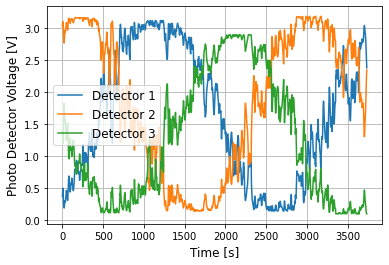

In [3]:
time = np.arange(len(decimation_data["DC1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data[f"DC{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("DC.pdf")

# RMS Values

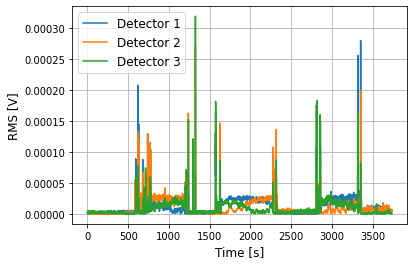

In [4]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.sqrt(decimation_data[f"X{channel}"] ** 2 + decimation_data[f"Y{channel}"] ** 2), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("RMS.pdf")

# Response Phases

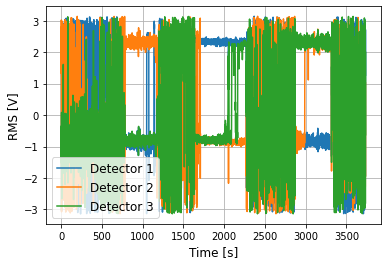

In [5]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.arctan2(decimation_data[f"Y{channel}"], decimation_data[f"X{channel}"]), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("RMS.pdf")

# PTI Signal

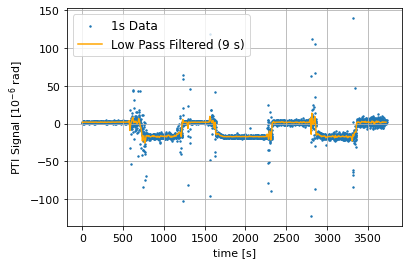

In [6]:
pti_mean = np.mean(np.array(pti_data["PTI Signal"]).reshape(-1, 9), axis=1)
time_mean = np.arange(pti_mean.size)
time_mean *= 9
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.scatter(time, -pti_data["PTI Signal"] * 1e6, s=2, label="1s Data")
plt.plot(time_mean, -pti_mean * 1e6, label="Low Pass Filtered (9 s)", color="orange")
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.legend(fontsize=12)
plt.ylabel("PTI Signal [$10^{-6}$ rad]", fontsize=11)
plt.savefig("pti.pdf", dpi=400, bbox_inches="tight")

# Interferometric Phase

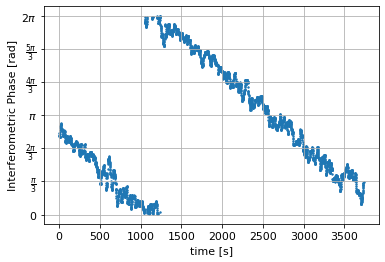

In [27]:
phases = pti_data["Interferometric Phase"].to_numpy()
phases[np.where(phases < 0)] += 2 * np.pi
_, ax = plt.subplots()
plt.yticks([0, np.pi / 3, 2 / 3 * np.pi, np.pi, 4 * np.pi / 3, 5 * np.pi / 3, 2 * np.pi],
           ['$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$', r'$\frac{4\pi}{3}$', r'$\frac{5\pi}{3}$', r'$2\pi$'])
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.scatter(time, phases, s=2)
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.ylabel("Interferometric Phase [rad]", fontsize=11)
plt.savefig("phase.pdf", dpi=400, bbox_inches="tight")

# Automatic Phase Scan

## Distribution of the interferometric phases

[3.17214392]


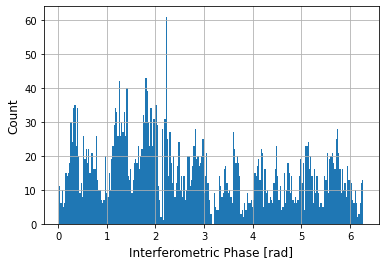

In [41]:
bins = plt.hist(phases, bins=240)
print(bins[1][np.where(bins[0] == 0)])
plt.grid()
plt.xlabel("Interferometric Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

The interferometric phase shows the trend to a uniform distribution. However, it seems like that their exist still interferometric phases
which have a higher occurrence than others.

## Basic Idea of Algorithm
Formally we represent the phases as a set of multi-sets. Therefor we discretize the range 0 to $2\pi$ into $n$ different values (basing on the histogram above it may be more useful to choice no equal steps). Formally we obtain a sequence $$a_i = \frac{2 \pi}{n}i$$
If it holds for a given phase $\varphi$ the following $$a_i \le \varphi < a_{i+1}$$ then we put $\varphi$ into the $i$-th multi-set. While every multiset is not empty we can calculate output phases with exactly one element of every multi set.

We can implement this by using a directed Graph where node $v_i$ represents $a_i$. Every child of node $v_i$ (and there children) is a measured interferometric phase. We can calculate the output phases iff a BFS counts exactly $n$ nodes. If the result is less than $n$ we are still missing phases to calculate the output phases.

<center>
    <img src="graph.png">

In the figure above a possible graph for the phases is shown.
</center>

<center>
<img src="graph_phasescan.png">

In the figure above a possible graph for the phases after a coloring is shown.
    </center>

## Implementation

In [9]:
import networkx as nx

In [10]:
G = nx.Graph()

In [11]:
n = 5
roots = []
for i in range(1, n + 1):
    G.add_node(round(2 * np.pi / n * i, 2))
    roots.append(round(2 * np.pi / n * i, 2))

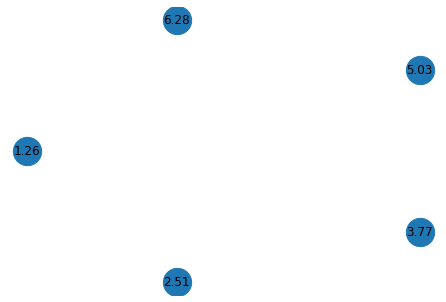

In [12]:
nx.draw_shell(G, with_labels=True, node_size=800)

In [13]:
for i in range(len(phases)):
    if i > 10:
        break
    k = int(n * phases[i] / (2 * np.pi))
    G.add_edge(i, list(G.nodes())[k])

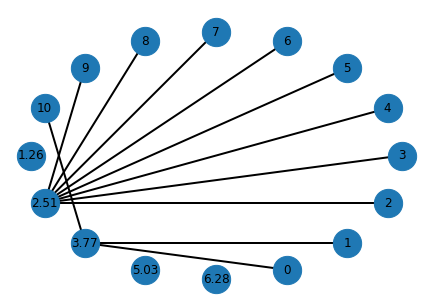

In [14]:
nx.draw_shell(G, with_labels=True, node_size=800, width=2)

The figure shows that the model works: every node is ordered to it's best-fit value. Every node $v_i$ of $a_i$ represents the root of a tree now. Hence we have a forest. Output phases can be calculated if the output degree of every node $v_i$ is at least 1.
If a node has an output degree > 1 we can color its node. If every tree has a colored node we can calculate with them the output phases and remove these nodes. At this moment the process repeats.

In [15]:
n = 250

def color_nodes(G, root_node=0, roots=[]):
    colored_nodes = []
    for node in range(root_node, n - 1):
        root = list(G.nodes)[node]
        if root:
            colored_node = next(nx.neighbors(G, root))
            colored_nodes.append(colored_node)
            G.remove_node(colored_node)
        else:
            return node
    return colored_nodes

In [16]:
phase_graph = nx.Graph()
roots = []
for i in range(1, n):
    phase_graph.add_node(2 * np.pi / n * i)
    roots.append(2 * np.pi / n * i)

for i in range(len(phases)):
    k = int(n * phases[i] / (2 * np.pi))
    phase_graph.add_edge(i, list(phase_graph.nodes())[k])



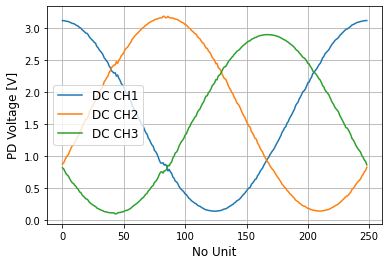

In [17]:
def get_values(colored_nodes):
    dc_1 = []
    dc_2 = []
    dc_3 = []
    phase_picked = []
    for t in colored_nodes:
        phase_picked.append(phases[t])
        dc_1.append(decimation_data["DC1"][t])
        dc_2.append(decimation_data["DC2"][t])
        dc_3.append(decimation_data["DC3"][t])
    return dc_1, dc_2, dc_3, phase_picked

colored_nodes = color_nodes(G=phase_graph, root_node=0, roots=roots)
dc_1, dc_2, dc_3, phase_picked = get_values(colored_nodes)

plt.plot(range(len(colored_nodes)), dc_1, label="DC CH1")
plt.plot(range(len(colored_nodes)), dc_2, label="DC CH2")
plt.plot(range(len(colored_nodes)), dc_3, label="DC CH3")

plt.xlabel("No Unit", fontsize=12)
plt.ylabel("PD Voltage [V]", fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [18]:
from phase_scan import PhaseScan

In [19]:
output_phases = [[], []]
for i in range(10):
    #phase_scan = PhaseScan(np.array([decimation_data["DC1"], decimation_data["DC2"], decimation_data["DC3"]]))
    phase_scan = PhaseScan(np.array([dc_1, dc_2, dc_3]))
    phase_scan.set_min()
    phase_scan.set_max()
    phase_scan.scale_data()
    PhaseScan.swapp_channels = True
    phase_scan.calulcate_output_phases()
    output_phases[0].append(PhaseScan.output_phases[1])
    output_phases[1].append(PhaseScan.output_phases[2])
    try:
        colored_nodes = color_nodes(G=phase_graph, root_node=0, roots=roots)
    except StopIteration:
        break
    dc_1, dc_2, dc_3, phase_picked = get_values(colored_nodes)
np.array(output_phases) / np.pi * 180

array([[238.06451613],
       [121.93548387]])

In [20]:
np.array([241.96721311,122.45901639]) - np.array([240, 120])

array([1.96721311, 2.45901639])

In [21]:
np.array([238.06451613,121.93548387]) - np.array([240, 120])

array([-1.93548387,  1.93548387])

This results shows that the results with the approach with graphs gives better results than the approach with taking into account every single value. The graph approch works like some kind of filter but needs however a good enough angle resolution. This results in a slowly phase scan. Since it is only rarely needed this isn't any issue.

$$\lim_{n \rightarrow \infty}\left(\frac{\sin{x}}{x}\right)^n = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}$$

$$\mathcal{F}(\lim_{n \rightarrow \infty}f_n(x)) = \lim_{n \rightarrow \infty}\mathcal{F}(f_n(x))$$